Running a Cluster Permutation Test

Exclusion:
    - DONE during preprocessing step 1: If excluded_ec/excluded_eo/excluded_hct corresponding column is 1, then corresponding run has already been excluded from the EEG data.
    - Data-quality related exclusion
      - BAD EPOCHS (DONE during preprocessing step 3): check % excluded epochs, if > 33%, check whether if comes from one channel, if yes interpolate that channel, if not exclude person/task.
      - BAD CHANNELS:
        - Permutation Test: exclude those with more bad channels than 33%  => Remaining!
  
  Imports:

In [1]:
import matplotlib.pyplot as plt
import mne
from mne import io
from mne.datasets import sample
from mne.stats import permutation_cluster_test
import numpy as np
import pandas as pd
import os
from mne.channels import find_ch_adjacency
import scipy
from scipy.stats import t



1) Find Exclusion Sub/Tasks

In [ ]:
# define dir for prep data csv, to detect bad subs
bhc_prep_output_dir = '/Users/denizyilmaz/Desktop/BrainTrain/Healthy Controls_BHC/BrainTrain_EEG_data_HC/HC_Preprocessed_until_ICA/sampling-250_bandpass-0.30-45.00_line-50_find_all_bads/HC_prep_interp_output_sampling-250_bandpass-0.30-45.00_line-50_find_all_bads_20250819.csv'
ssd_prep_output_dir = '/Users/denizyilmaz/Desktop/BrainTrain/BrainTrain_EEG_data/Preprocessed_until_ICA/sampling-250_bandpass-0.30-45.00_line-50_find_all_bads/prep_interp_output_sampling-250_bandpass-0.30-45.00_line-50_find_all_bads_20250821.csv'

# Load the csv data
bhc_prep_output = pd.read_csv(bhc_prep_output_dir)
ssd_prep_output = pd.read_csv(ssd_prep_output_dir)

# Get the list of bad subjects by detecting the subject_id, session, and task combination in the rows where "percent_interpolated_electrode" is above 33
bhc_bad_subs = bhc_prep_output[bhc_prep_output['percent_interpolated_electrode'] > 33][['subject_id', 'session', 'task']]
ssd_bad_subs = ssd_prep_output[ssd_prep_output['percent_interpolated_electrode'] > 33][['subject_id', 'session', 'task']]

# Exclude df = 
exclude_df = pd.concat([bhc_bad_subs, ssd_bad_subs], ignore_index=True)
print(exclude_df)


# create bad_subs_name list which is subject_id_session_task
bhc_bad_subs_names = []
for index, row in bhc_bad_subs.iterrows():
    bhc_bad_subs_names.append(f"{row['subject_id']}_{row['task']}_hep-ave.fif")
ssd_bad_subs_names= []
for index, row in ssd_bad_subs.iterrows():
    ssd_bad_subs_names.append(f"{row['subject_id']}_{row['session']}_{row['task']}_hep-ave.fif")


all_bad_subs_names = bhc_bad_subs_names + ssd_bad_subs_names
# Print the bad subjects
print("BHC Bad Subjects:")
print(bhc_bad_subs_names)
print("SSD Bad Subjects:")          
print(ssd_bad_subs_names)
print("All Bad Subjects:")
print(all_bad_subs_names)
    
#print(bhc_bad_subs["subject_id"])
#print(bhc_bad_subs)
#print(bhc_bad_subs_names)
#type(bhc_bad_subs)
#print(ssd_bad_subs_names)

# define dir for prep data csv, to detect bad subs
bhc_prep_output_dir = '/Users/denizyilmaz/Desktop/BrainTrain/Healthy Controls_BHC/BrainTrain_EEG_data_HC/HC_Preprocessed_until_ICA/sampling-250_bandpass-0.30-45.00_line-50_find_all_bads/HC_prep_interp_output_sampling-250_bandpass-0.30-45.00_line-50_find_all_bads_20250819.csv'
ssd_prep_output_dir = '/Users/denizyilmaz/Desktop/BrainTrain/BrainTrain_EEG_data/Preprocessed_until_ICA/sampling-250_bandpass-0.30-45.00_line-50_find_all_bads/prep_interp_output_sampling-250_bandpass-0.30-45.00_line-50_find_all_bads_20250821.csv'

# Load the csv data
bhc_prep_output = pd.read_csv(bhc_prep_output_dir)
ssd_prep_output = pd.read_csv(ssd_prep_output_dir)

# Get the list of bad subjects by detecting the subject_id, session, and task combination in the rows where "percent_interpolated_electrode" is above 33
bhc_bad_subs = bhc_prep_output[bhc_prep_output['percent_interpolated_electrode'] > 33][['subject_id', 'session', 'task']]
ssd_bad_subs = ssd_prep_output[ssd_prep_output['percent_interpolated_electrode'] > 33][['subject_id', 'session', 'task']]

# Exclude df = 
exclude_df = pd.concat([bhc_bad_subs, ssd_bad_subs], ignore_index=True)
print(exclude_df)


# create bad_subs_name list which is subject_id_session_task
bhc_bad_subs_names = []
for index, row in bhc_bad_subs.iterrows():
    bhc_bad_subs_names.append(f"{row['subject_id']}_{row['task']}_hep-ave.fif")
ssd_bad_subs_names= []
for index, row in ssd_bad_subs.iterrows():
    ssd_bad_subs_names.append(f"{row['subject_id']}_{row['session']}_{row['task']}_hep-ave.fif")


all_bad_subs_names = bhc_bad_subs_names + ssd_bad_subs_names
# Print the bad subjects
print("BHC Bad Subjects:")
print(bhc_bad_subs_names)
print("SSD Bad Subjects:")          
print(ssd_bad_subs_names)
print("All Bad Subjects:")
print(all_bad_subs_names)
    
#print(bhc_bad_subs["subject_id"])
#print(bhc_bad_subs)
#print(bhc_bad_subs_names)
#type(bhc_bad_subs)
#print(ssd_bad_subs_names)



2) Import Evoked Objects, which do not include more than 33% interpolated channels & Create dictionaries storing all evoked data. 

In [ ]:
# Define paths
base_path = '/Users/denizyilmaz/Desktop/BrainTrain/BrainTrain_EEG_data/Preprocessed_until_ICA/sampling-250_bandpass-0.30-45.00_line-50_find_all_bads/Preprocessed_ICA_applied_on_raw/HEPs/HEPs_hep-epoch--0.25-0.70_baseline--0.12--0.03_epoch-reject-1.50e-04_33%-bad-epochs-threshold_HEP-time_window-0.45-0.50'
base_path_hc = '/Users/denizyilmaz/Desktop/BrainTrain/Healthy Controls_BHC/BrainTrain_EEG_data_HC/HC_Preprocessed_until_ICA/sampling-250_bandpass-0.30-45.00_line-50_find_all_bads/HC_Preprocessed_ICA_applied_on_raw/HEPs/HEPs_hep-epoch--0.25-0.70_baseline--0.12--0.03_epoch-reject-1.50e-04_33%-bad-epochs-threshold_HEP-time_window-0.45-0.50'

# Function to process data folders
def import_evoked_data(base_path, task_dictionaries, all_bad_subs_names, has_session_folder=False):
    for folder_name in os.listdir(base_path):
        # Construct folder path
        folder_path = os.path.join(base_path, folder_name)
        if has_session_folder:
            folder_path = os.path.join(folder_path, "ses-V1")
        
        if not os.path.isdir(folder_path):
            continue  # Skip non-folder entries

        print(f"Processing folder: {folder_path}")

        # Loop over the task subfolders
        for subfolder_name in os.listdir(folder_path):
            subfolder_path = os.path.join(folder_path, subfolder_name)

            if not os.path.isdir(subfolder_path):
                continue

            # Check if the subfolder name matches one of the tasks
            task_key = None
            if subfolder_name == "task-eyes-closed":
                task_key = "ec"
            elif subfolder_name == "task-eyes-open":
                task_key = "eo"
            elif subfolder_name == "task-hct":
                task_key = "hct"
            else:
                print(f"Unknown subfolder: {subfolder_name}")
                continue

            for file_name in os.listdir(subfolder_path):
                print(file_name)
                # Check for exclusions
                excluded = False
                if file_name in all_bad_subs_names:
                    print(f"Excluded due to bad subject: {file_name}")
                    excluded = True
                    break

                #for row in exclude_df.itertuples(index=False):
                #    subject_id, session, task = row.subject_id, row.session, row.task
                #    if subject_id in file_name and task in file_name and (not has_session_folder or session in file_name):
                #        print(f"Excluded due to {subject_id}-{session}-{task}: {file_name}")
                #        excluded = True
                #        break

                if excluded:
                    continue

                # Import the data if not excluded
                file_path = os.path.join(subfolder_path, file_name)
                try:
                    data = mne.read_evokeds(file_path, verbose=False)
                    task_dictionaries[task_key][file_name] = data
                    print(f"Imported: {file_name}")
                except Exception as e:
                    print(f"Error importing {file_name} from {file_path}: {e}")

# Create dictionaries for SSD data
ssd_data_v1 = {"ec": {}, "eo": {}, "hct": {}}
import_evoked_data(base_path, ssd_data_v1, all_bad_subs_names, has_session_folder=True)

# Print the keys of the imported SSD data
print(f"Final imported SSD ec keys: {list(ssd_data_v1['ec'].keys())}")
print(f"Final imported SSD eo keys: {list(ssd_data_v1['eo'].keys())}")
print(f"Final imported SSD hct keys: {list(ssd_data_v1['hct'].keys())}")

# Create dictionaries for HC data
hc_data = {"ec": {}, "eo": {}, "hct": {}}
import_evoked_data(base_path_hc, hc_data, all_bad_subs_names, has_session_folder=False)

# Print the keys of the imported HC data
print(f"Final imported HC ec keys: {list(hc_data['ec'].keys())}")
print(f"Final imported HC eo keys: {list(hc_data['eo'].keys())}")
print(f"Final imported HC hct keys: {list(hc_data['hct'].keys())}")


3.1) Get the time window & task & channels of interest for SPATIAL CLUSTER PERM TEST

In [ ]:

# Define the time window of interest
time_min = 0.45 #0.45
time_max = 0.5#0.7 #0.50
# Specify the task and channels
tasks = ["ec", "eo", "hct"]
#task = "ec"  # Example: "ec", "eo", or "hct"
channels_of_interest = list(range(0, 31))  # Example: indices of the desired channels

# Extract SSD group data
ssd_group_data_for_spatial_test = {"ec": [], "eo": [], "hct": []}
for task in tasks:
    temp_list = []

    for evoked in ssd_data_v1[task].values():
        if isinstance(evoked, list):  # Check if it's a list
            evoked = evoked[0]       # Take the first element
            time_mask = (evoked.times >= time_min) & (evoked.times <= time_max)
            data = evoked.data[channels_of_interest, :][:, time_mask]  # Select channels
            ssd_group_data_for_spatial_test[task].append(data)
            
            #ssd_group_data.append(data)
            adjacency, ch_nameslist = find_ch_adjacency(evoked.info, ch_type='eeg')  # Assuming `hc_data` contains the info attribute

    # make array
    ssd_group_data_for_spatial_test[task] = np.array(ssd_group_data_for_spatial_test[task])  # Shape:
ssd_group_data_for_spatial_test_ec_array = ssd_group_data_for_spatial_test["ec"]
ssd_group_data_for_spatial_test_eo_array = ssd_group_data_for_spatial_test["eo"]
ssd_group_data_for_spatial_test_hct_array = ssd_group_data_for_spatial_test["hct"]

# Extract HC group data
hc_group_data_for_spatial_test = {"ec": [], "eo": [], "hct": []}
for task in tasks:
    temp_list = []
    for evoked in hc_data[task].values():
        if isinstance(evoked, list):  # Check if it's a list
            evoked = evoked[0]       # Take the first element
            time_mask = (evoked.times >= time_min) & (evoked.times <= time_max)
            data = evoked.data[channels_of_interest, :][:, time_mask]  # Select channels
            hc_group_data_for_spatial_test[task].append(data)
            
            #ssd_group_data.append(data)
            adjacency, ch_nameslist = find_ch_adjacency(evoked.info, ch_type='eeg')  # Assuming `hc_data` contains the info attribute

    # make array
    hc_group_data_for_spatial_test[task] = np.array(hc_group_data_for_spatial_test[task])  # Shape:

hc_group_data_for_spatial_test_ec_array = hc_group_data_for_spatial_test["ec"]
hc_group_data_for_spatial_test_eo_array = hc_group_data_for_spatial_test["eo"]
hc_group_data_for_spatial_test_hct_array = hc_group_data_for_spatial_test["hct"]


shape_ssd = ssd_group_data_for_spatial_test_ec_array.shape
shape_hc = hc_group_data_for_spatial_test_ec_array.shape
print(f"SSD group data shape: {shape_ssd} indicating {shape_ssd[0]} subjects, {shape_ssd[1]} channels, {shape_ssd[2]} time points")
print(f"HC group data shape: {shape_hc} indicating {shape_hc[0]} subjects, {shape_hc[1]} channels, {shape_hc[2]} time points")

# average ssd_group_data on time domain
ssd_group_data_time_avg = np.mean(ssd_group_data_for_spatial_test_ec_array, axis=2)
hc_group_data_time_avg = np.mean(hc_group_data_for_spatial_test_ec_array, axis=2)

print("SSD group data shape after averaging over time domain:", ssd_group_data_time_avg.shape, "indicating ", ssd_group_data_time_avg.shape[0], "subjects, ", ssd_group_data_time_avg.shape[1], "channels")
print("HC group data shape after averaging over time domain:", hc_group_data_time_avg.shape, "indicating ", hc_group_data_time_avg.shape[0], "subjects, ", hc_group_data_time_avg.shape[1], "channels")


3.2) Get the time window & task & channels of interest for SPATIO-TEMPORAL CLUSTER PERM TEST

In [ ]:
# Define the time window of interest
time_min = 0.15 #0.45
time_max = 0.55#0.7 #0.50
# Specify the task and channels
tasks = ["ec", "eo", "hct"]
channels_of_interest = list(range(0, 31))  # Example: indices of the desired channels

# Extract SSD group data
ssd_group_data_for_spatiotemporal_test = {"ec": [], "eo": [], "hct": []}
for task in tasks:
    for evoked in ssd_data_v1[task].values():
        if isinstance(evoked, list):  # Check if it's a list
            evoked = evoked[0]       # Take the first element
            time_mask = (evoked.times >= time_min) & (evoked.times <= time_max)
            data = evoked.data[channels_of_interest, :][:, time_mask]  # Select channels
            ssd_group_data_for_spatiotemporal_test[task].append(data)
            
            #ssd_group_data.append(data)
            adjacency, ch_nameslist = find_ch_adjacency(evoked.info, ch_type='eeg')  # Assuming `hc_data` contains the info attribute
            # Subset adjacency to match channels_of_interest
            ch_idx = channels_of_interest
            adjacency = adjacency[ch_idx, :][:, ch_idx]  # Subset adjacency
            
            # Combine spatial (EEG) and temporal adjacency
            n_times = data.shape[1]  # Number of time points after masking
            # temporal_adj = mne.stats.combine_adjacency(n_times, n_times)  # Linear time adjacency
            temporal_adj = np.eye(n_times, k=1) + np.eye(n_times, k=-1)  # neighbors are adjacent time points
            combined_adj = mne.stats.combine_adjacency(adjacency, temporal_adj)
            print("Channels:", channels_of_interest)
            print("Spatial Adjacency shape:", adjacency.shape)
            print("Combined adjacency shape:", combined_adj.shape)



    # make array
    ssd_group_data_for_spatiotemporal_test[task] = np.array(ssd_group_data_for_spatiotemporal_test[task])  # Shape:
ssd_group_data_for_spatiotemporal_test_ec_array = ssd_group_data_for_spatiotemporal_test["ec"]
ssd_group_data_for_spatiotemporal_test_eo_array = ssd_group_data_for_spatiotemporal_test["eo"]
ssd_group_data_for_spatiotemporal_test_hct_array = ssd_group_data_for_spatiotemporal_test["hct"]

# Extract HC group data
hc_group_data_for_spatiotemporal_test = {"ec": [], "eo": [], "hct": []}
for task in tasks:
    for evoked in hc_data[task].values():
        if isinstance(evoked, list):  # Check if it's a list
            evoked = evoked[0]       # Take the first element
            time_mask = (evoked.times >= time_min) & (evoked.times <= time_max)
            data = evoked.data[channels_of_interest, :][:, time_mask]  # Select channels
            hc_group_data_for_spatiotemporal_test[task].append(data)
            
            #ssd_group_data.append(data)
            adjacency, ch_nameslist = find_ch_adjacency(evoked.info, ch_type='eeg')  # Assuming `hc_data` contains the info attribute
            # Subset adjacency to match channels_of_interest
            ch_idx = channels_of_interest
            adjacency = adjacency[ch_idx, :][:, ch_idx]  # Subset adjacency

            # Combine spatial (EEG) and temporal adjacency
            n_times = data.shape[1]  # Number of time points after masking
            # temporal_adj = mne.stats.combine_adjacency(n_times, n_times)  # Linear time adjacency
            temporal_adj = np.eye(n_times, k=1) + np.eye(n_times, k=-1)  # neighbors are adjacent time points
            combined_adj = mne.stats.combine_adjacency(adjacency, temporal_adj)
            print("Channels:", channels_of_interest)
            print("Spatial Adjacency shape:", adjacency.shape)
            print("Combined adjacency shape:", combined_adj.shape)

   

    # make array
    hc_group_data_for_spatiotemporal_test[task] = np.array(hc_group_data_for_spatiotemporal_test[task])  # Shape:

hc_group_data_for_spatiotemporal_test_ec_array = hc_group_data_for_spatiotemporal_test["ec"]
hc_group_data_for_spatiotemporal_test_eo_array = hc_group_data_for_spatiotemporal_test["eo"]
hc_group_data_for_spatiotemporal_test_hct_array = hc_group_data_for_spatiotemporal_test["hct"]


shape_ssd = ssd_group_data_for_spatiotemporal_test_ec_array.shape
shape_hc = hc_group_data_for_spatiotemporal_test_ec_array.shape
print(f"SSD group data shape: {shape_ssd} indicating {shape_ssd[0]} subjects, {shape_ssd[1]} channels, {shape_ssd[2]} time points")
print(f"HC group data shape: {shape_hc} indicating {shape_hc[0]} subjects, {shape_hc[1]} channels, {shape_hc[2]} time points")

# average ssd_group_data on time domain
ssd_group_data_time_avg = np.mean(ssd_group_data_for_spatial_test_ec_array, axis=2)
hc_group_data_time_avg = np.mean(hc_group_data_for_spatial_test_ec_array, axis=2)

print("SSD group data shape after averaging over time domain:", ssd_group_data_time_avg.shape, "indicating ", ssd_group_data_time_avg.shape[0], "subjects, ", ssd_group_data_time_avg.shape[1], "channels")
print("HC group data shape after averaging over time domain:", hc_group_data_time_avg.shape, "indicating ", hc_group_data_time_avg.shape[0], "subjects, ", hc_group_data_time_avg.shape[1], "channels")


4) TRY FDR CORRECTED MASS UNIVAR T TEST

In [ ]:
# do the t-test on only the frontal_central regions
frontal_central_regions= ['Fp1', 'Fp2', 'F3', 'F4', 'F7', 'F8','Fz', 'FC1', 'FC2', 'FC5', 'FC6', 'C3', 'C4', 'Cz']

# Get the indices of the frontal_central_regions in the channel names
frontal_central_indices = [evoked.ch_names.index(ch) for ch in frontal_central_regions if ch in evoked.ch_names]
# Extract the data for the frontal_central_regions
ssd_group_data_frontal_central = ssd_group_data_time_avg[:, frontal_central_indices]
hc_group_data_frontal_central = hc_group_data_time_avg[:, frontal_central_indices]

# Perform mass univariate t-tests on the frontal_central_regions    
X1 = ssd_group_data_time_avg # ssd_group_data_frontal_central # 
X2 = hc_group_data_time_avg # hc_group_data_frontal_central # 

n_participants, n_channels = X1.shape

# T-test across trials 
print("  performing t-test UNCORRECTED.. coming up \n")
t_vals = np.zeros((n_channels))
p_vals = np.zeros((n_channels))

for ch in range(n_channels):
    t_vals[ch], p_vals[ch] = scipy.stats.ttest_ind(X1[:, ch], X2[:, ch])

# print t and p values in non scientific notation
np.set_printoptions(suppress=True)
print("T-values:", t_vals)
print("P-values:", p_vals)

# match these values to the respective channel
# print the channel names
print("Channel names:", evoked.ch_names)
# print the channel names and corresponding t and p values
for ch, t_val, p_val in zip(evoked.ch_names, t_vals, p_vals):
    print(f"Channel: {ch}, T-value: {t_val}, P-value: {p_val}")

# FDR correction
print("\n  correcting for multiple comparisons... coming up \n")
p_vals_flat = p_vals.ravel()
rej, p_vals_corrected = mne.stats.fdr_correction(p_vals_flat, alpha=0.05)
rej = rej.reshape(p_vals.shape)
p_vals_corrected = p_vals_corrected.reshape(p_vals.shape)
# print fdr corrected values per channel
for ch, t_val, p_val in zip(evoked.ch_names, t_vals, p_vals_corrected):
    print(f"Channel: {ch}, T-value: {t_val}, FDR-corrected P-value: {p_val}")
    if p_val < 0.05:
        print(f"\n  Oh yay \n  Significant channel: {ch}, T-value: {t_val}, FDR-corrected P-value: {p_val} \n ")   


# create mask and plotting
significant_p_vals = p_vals_corrected < 0.05
full_mask = significant_p_vals.copy()
#full_mask = np.zeros((len(evoked.ch_names),), dtype=bool)
#for idx, is_significant in zip(frontal_central_indices, significant_p_vals):
#    full_mask[idx] = is_significant

# Visualize Results

# Compute the grand average accross all patients
hc_ec_evokeds_all_subs_list = list(hc_data[task].values())
# Using a list comprehension to extract the first (and only) element from each inner list
hc_ec_evokeds_all_subs_flat = [evoked_list[0] for evoked_list in hc_ec_evokeds_all_subs_list]
# grand average
hc_ec_grand_average_hep_evoked = mne.grand_average(hc_ec_evokeds_all_subs_flat)

ssd_ec_evokeds_all_subs_list = list(ssd_data_v1["hct"].values())
# Using a list comprehension to extract the first (and only) element from each inner list
ssd_ec_evokeds_all_subs_flat = [evoked_list[0] for evoked_list in ssd_ec_evokeds_all_subs_list]
# grand average
ssd_ec_grand_average_hep_evoked = mne.grand_average(ssd_ec_evokeds_all_subs_flat)

# make a list containing both_evokeds_all_subs_list = ssd_ec_grand_average_hep_evoked and hc_ec_grand_average_hep_evoked
both_evokeds_all_subs_list = [ssd_ec_grand_average_hep_evoked, hc_ec_grand_average_hep_evoked]

# mark evokeds
ssd_ec_grand_average_hep_evoked.comment = 'SSD Group'
hc_ec_grand_average_hep_evoked.comment = 'HC Group'

colors = {
    'SSD Group': '#FFD700',   # green
    'HC Group': '#9ACD32',   # gold
}


# get picks 
picks = np.where(full_mask)[0]  # Indices of significant channels
picked_names = [ch_nameslist[pick] for pick in picks]  # Retrieve channel names

# plot the first signigicant channel 

# title
title = f"Grand Average HEP Comparison during {task} at {picked_names[0]}"


# Plot the grand average evoked responses for both groups
comparison_plot = mne.viz.plot_compare_evokeds(
    both_evokeds_all_subs_list,
    picks=picked_names[0],
    colors=colors,
    split_legend=True,
    show_sensors=True,
    title=title,
    vlines=[0.4, 0.552], # time_min, time_max
)

# save plot under /Users/denizyilmaz/Desktop/BrainTrain/Results/TAC_2_analysis/HEPs/exploratory
output_dir = '/Users/denizyilmaz/Desktop/BrainTrain/Results/TAC_2_analysis/HEPs/exploratory'
output_path = os.path.join(output_dir, f"Grand_Average_HEP_Comparison_{task}_{picked_names[0]}.png")
comparison_plot[0].savefig(output_path, dpi=300)



# We need an evoked object to plot the image to be masked
#evoked = mne.combine_evoked([ssd_ec_grand_average_hep_evoked, hc_ec_grand_average_hep_evoked], weights=[1, -1])  # calculate difference wave SSD-HC
#time_unit = dict(time_unit="s")
# picks should be channels where with index where full_mask is True
#picked_indices = [evoked.info['ch_names'].index(name) for name in picked_names]
#evoked.plot_joint(title="SSD - HC HEP", ts_args=dict(time_unit='s'),times=[0.4, 0.552], picks = 'P4' )  # <-- pass times directly here)# 

# Masked topomap of t-values
#evoked.data = t_vals.reshape(1, -1)  # Overwrite evoked data with t-values for visualization
#evoked.plot_topomap(
#    times=0,  # Dummy time, as t-values are static
#    ch_type='eeg',
#    mask=full_mask,
#    mask_params=dict(marker='o', markerfacecolor='r') #,
#    #title="Frontal-Central Regions: T-Values (Significant Channels Highlighted)"
#)



In [ ]:
mne.stats.spatio_temporal_cluster_test?


In [ ]:
ssd_group_data

In [215]:
F_obs, clusters, cluster_pv, H0 = mne.stats.spatio_temporal_cluster_test(
    [ssd_group_data_for_spatiotemporal_test_hct_array, hc_group_data_for_spatiotemporal_test_hct_array],# [ssd_group_data, hc_group_data],
    adjacency=combined_adj,
    n_permutations= 1000,
    threshold=None,
    tail=0,
    buffer_size=None,
    out_type='indices',
    stat_fun=None,
    verbose=True
)

Using a threshold of 3.932438
stat_fun(H1): min=7.074598286620289e-06 max=14.016171238297154
Running initial clustering …
Found 24 clusters


/var/folders/hw/ptzt2r6n08q4_jhx1fpg9fpm0000gn/T/ipykernel_76842/3006252368.py:1: RuntimeWarning: Ignoring argument "tail", performing 1-tailed F-test
  F_obs, clusters, cluster_pv, H0 = mne.stats.spatio_temporal_cluster_test(


  0%|          | Permuting : 0/999 [00:00<?,       ?it/s]

In [170]:
ch_idx, time_idx = clusters[5]  # or whichever cluster
times_in_cluster = ssd_ec_grand_average_hep_evoked.times[time_idx]
times_in_cluster



array([-0.152, -0.148, -0.144, -0.14 , -0.136, -0.132, -0.128, -0.124,
       -0.12 , -0.116, -0.112, -0.108, -0.104, -0.1  , -0.248, -0.244,
       -0.24 , -0.236, -0.232, -0.228, -0.224, -0.22 , -0.216, -0.212,
       -0.176, -0.172, -0.168, -0.164, -0.16 , -0.156, -0.152, -0.148,
       -0.144, -0.14 , -0.136, -0.132, -0.128, -0.124, -0.12 , -0.116,
       -0.112, -0.108, -0.104, -0.1  , -0.248, -0.244, -0.228, -0.224,
       -0.22 , -0.216, -0.164, -0.16 , -0.156, -0.152, -0.148, -0.112,
       -0.108, -0.104, -0.1  , -0.16 , -0.156, -0.152, -0.148, -0.144,
       -0.14 , -0.1  , -0.248, -0.244, -0.24 , -0.236, -0.232, -0.228,
       -0.224, -0.22 , -0.216, -0.212, -0.208, -0.204, -0.2  , -0.196,
       -0.192, -0.188, -0.184, -0.18 , -0.176, -0.172, -0.168, -0.164,
       -0.16 , -0.156, -0.152, -0.148, -0.144, -0.14 , -0.136, -0.132,
       -0.128, -0.124, -0.12 , -0.116, -0.112, -0.108, -0.104, -0.1  ])

Cluster 0: p = 0.952
Cluster 1: p = 0.927
Cluster 2: p = 1.0
Cluster 3: p = 0.991
Cluster 4: p = 0.88
Cluster 5: p = 0.998
Cluster 6: p = 0.977
Cluster 7: p = 0.051
Cluster 8: p = 0.418
Cluster 9: p = 1.0
Cluster 10: p = 0.98
Cluster 11: p = 0.979
Cluster 12: p = 1.0
Cluster 13: p = 0.97
Cluster 14: p = 0.979
Cluster 15: p = 0.808
Cluster 16: p = 1.0
Cluster 17: p = 0.998
Cluster 18: p = 0.998
Cluster 19: p = 0.995
Cluster 20: p = 0.968
Cluster 21: p = 1.0
Cluster 22: p = 0.979
Cluster 23: p = 1.0
0 significant clusters


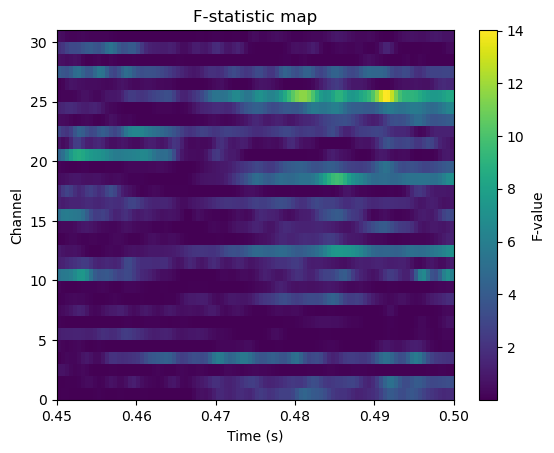

In [216]:
for i, p_val in enumerate(cluster_pv):
    print(f"Cluster {i}: p = {p_val}")
significant_clusters = [clusters[i] for i, p in enumerate(cluster_pv) if p < 0.05]
print(f"{len(significant_clusters)} significant clusters")

import matplotlib.pyplot as plt

# Flatten F_obs to 2D (channels × times)
F_obs_2d = F_obs.reshape(n_channels, n_times)

plt.imshow(F_obs_2d, aspect='auto', origin='lower', 
           extent=[tmin, tmax, 0, n_channels])
plt.colorbar(label='F-value')
plt.xlabel('Time (s)')
plt.ylabel('Channel')
plt.title('F-statistic map')
plt.show()




In [210]:
for i, p_val in enumerate(cluster_pv):
    if p_val < 0.10:  # significant clusters
        ch_idx, time_idx = clusters[i]
        print(f"\nCluster {i} (p={p_val:.4f}):")
        print("Channels:", [channels_of_interest[ch] for ch in ch_idx])
        print("Times (s):", [tmin + (tmax-tmin)*t/n_times for t in time_idx])


In [160]:
ch_idx, time_idx = clusters[5]

channels_in_cluster = np.unique([channels_of_interest[ch] for ch in ch_idx])
channel_names_in_cluster = [evoked.ch_names[ch] for ch in channels_in_cluster]
times_in_cluster = np.unique([tmin + (tmax-tmin) * t / n_times for t in time_idx])

print(f"Cluster 5 (p={cluster_pv[5]:.3f}):")
print("Channels:", channels_in_cluster)
print("Time range: {:.3f} - {:.3f} s".format(times_in_cluster[0], times_in_cluster[-1]))
print("Cluster 5 (p={:.3f}) channels:".format(cluster_pv[5]))
print(channel_names_in_cluster)



Cluster 5 (p=0.029):
Channels: [12 14 18 19 24 25]
Time range: 0.450 - 0.499 s
Cluster 5 (p=0.029) channels:
['C3', 'C4', 'CP1', 'CP2', 'Pz', 'P4']


In [213]:
import numpy as np

# Get cluster 5 indices
ch_idx, time_idx = clusters[5]

# Extract data for this cluster (channels × times)
ssd_cluster_data = ssd_group_data[:, ch_idx[:, None], time_idx].mean(axis=(1,2))
hc_cluster_data = hc_group_data[:, ch_idx[:, None], time_idx].mean(axis=(1,2))

# Compare means
mean_ssd = np.mean(ssd_cluster_data)
mean_hc = np.mean(hc_cluster_data)

print(f"Mean SSD: {mean_ssd}")
print(f"Mean HC: {mean_hc}")

if mean_ssd > mean_hc:
    print("SSD > HC in this cluster")
else:
    print("HC > SSD in this cluster")


IndexError: index 26 is out of bounds for axis 2 with size 12

In [162]:
import matplotlib.pyplot as plt
import numpy as np

# Define the significance threshold
p_accept = 0.05  # as you wanted < 0.10
good_cluster_inds = np.where(cluster_pv < p_accept)[0]

colors = ["crimson", "steelblue"]  # one color per cluster

# organize data for plotting
evokeds = {'ssd': ssd_ec_grand_average_hep_evoked, 'hc': hc_ec_grand_average_hep_evoked}
# to see the CI s I need to make 2 lists of all subs evokeds !

# Loop over significant clusters
for i, clu_idx in enumerate(good_cluster_inds):
    for evoked in evokeds.values():
        ch_idx, time_idx = clusters[clu_idx]
        ch_idx = np.unique(ch_idx)
        time_idx = np.unique(time_idx)

        # Create time vector for this cluster
        times = evoked_example.times[time_idx]

        # add new axis for time courses and plot time courses
        #ax_signals = divider.append_axes("right", size="300%", pad=1.2)
        title = f"Cluster #{clu_idx + 1}, {len(ch_inds)} sensor"
        #if len(ch_inds) > 1:
        #    title += "s (mean)"
        plot_compare_evokeds(
            evokeds,
            title=title,
            picks=channels_in_cluster,
            #axes=ax_signals,
            colors=colors,
            #linestyles=linestyles,
            #show=False,
            split_legend=True,
            truncate_yaxis="auto",
        )

    # plot temporal cluster extent
    ymin, ymax = ax_signals.get_ylim()
    ax_signals.fill_betweenx(
        (ymin, ymax), sig_times[0], sig_times[-1], color="orange", alpha=0.3
    )

        # Average over cluster channels for each subject
        ssd_vals = np.array([evoked.data[ch_idx, time_idx].mean(axis=1) for evoked in ssd_data_v1["ec"].values()])
        hc_vals  = np.array([evoked.data[ch_idx, time_idx].mean(axis=1) for evoked in hc_data["ec"].values()])

        # Average over subjects
        ssd_mean = ssd_vals.mean(axis=0)
        hc_mean  = hc_vals.mean(axis=0)

        # Plot
        plt.plot(times, ssd_mean, color=colors[i], linestyle='--', label=f"Cluster {i+1} SSD")
        plt.plot(times, hc_mean, color=colors[i], linestyle='-',  label=f"Cluster {i+1} HC")

        # Shade cluster extent
        plt.axvspan(times[0], times[-1], color=colors[i], alpha=0.1)

    plt.xlabel("Time (s)")
    plt.ylabel("Amplitude (µV)")
    plt.title(f"Significant clusters ERP ({task.upper()})")
    plt.legend()
    plt.show()


IndentationError: unexpected indent (1603457678.py, line 47)

combining channels using GFP (eeg channels)
combining channels using GFP (eeg channels)


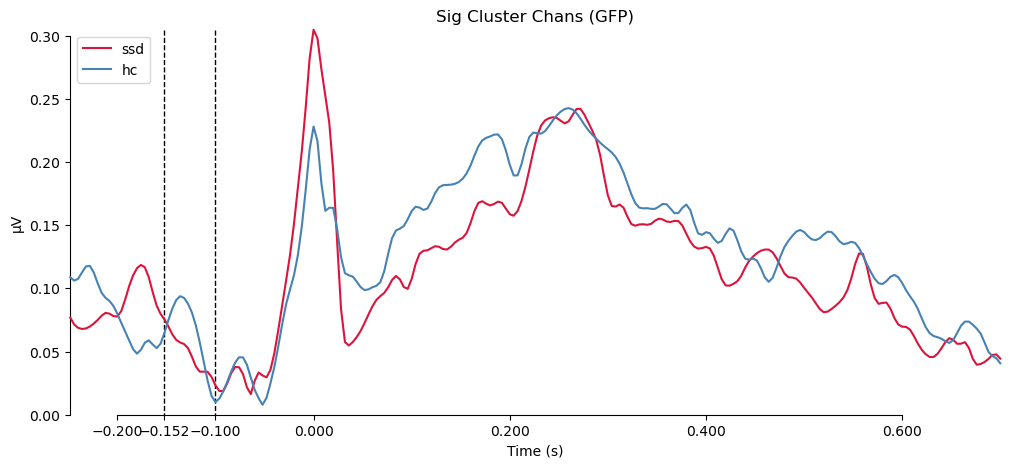

In [214]:
fig, ax = plt.subplots(figsize=(12, 5))  # create a figure and axes

# Plot ERPs on this axes
plot_compare_evokeds(
    evokeds,
    picks=channels_in_cluster,
    colors=colors,
    split_legend=True,
    truncate_yaxis="auto",
    axes=ax,             # <-- pass the axes here
    title="Sig Cluster Chans",
    vlines = [times_in_cluster[0], times_in_cluster[-1]], # mark the time window of the cluster
    ci = 0.68
)

# Highlight the significant temporal window
ymin, ymax = ax.get_ylim()
ax.axvspan(times_in_cluster[0], times_in_cluster[-1], color="orange", alpha=0.3, label="Significant cluster")
ax.set_ylim(ymin, ymax)  # ensure y-limits stay fixed

plt.show()


In [143]:
evoked.data

array([[-0.00000024, -0.0000002 , -0.00000018, ...,  0.00000015,
         0.00000015,  0.00000012],
       [-0.0000001 , -0.00000006, -0.00000003, ...,  0.00000012,
         0.00000012,  0.00000011],
       [-0.0000002 , -0.00000017, -0.00000014, ..., -0.00000004,
        -0.00000003, -0.00000007],
       ...,
       [ 0.        , -0.00000004, -0.00000006, ...,  0.00000017,
         0.00000013,  0.00000013],
       [ 0.00000012,  0.00000007,  0.00000002, ...,  0.00000005,
         0.00000001,  0.        ],
       [ 0.00000018,  0.00000016,  0.00000012, ...,  0.00000005,
         0.00000001,  0.00000002]])

<Evoked | 'R-peak' (average, N=253), -0.248 – 0.7 s, baseline -0.125 – -0.025 s, 31 ch, ~100 KiB>


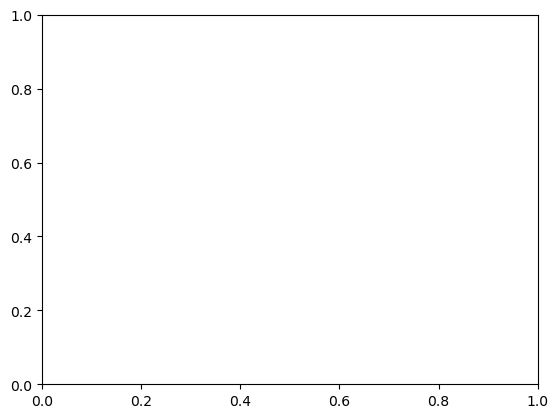

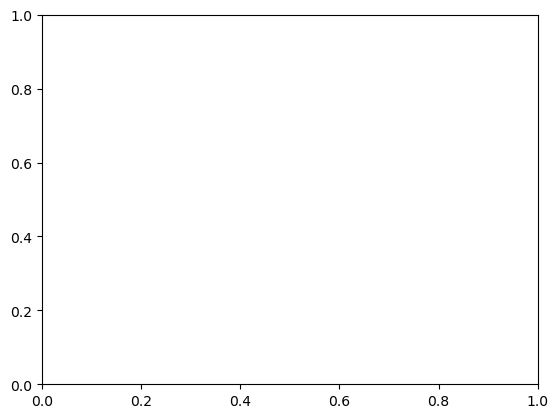

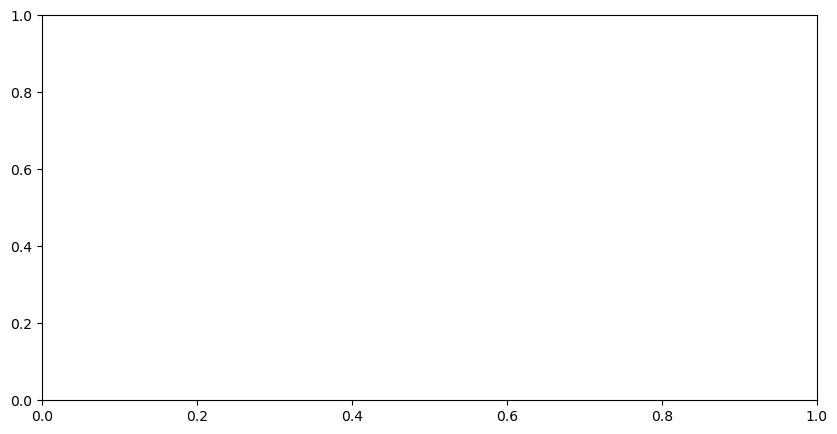

<Figure size 800x500 with 0 Axes>

<Figure size 800x500 with 0 Axes>

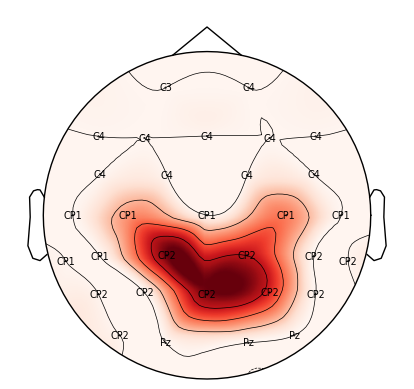

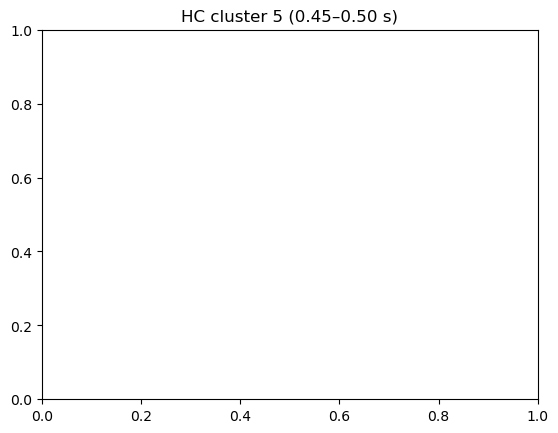

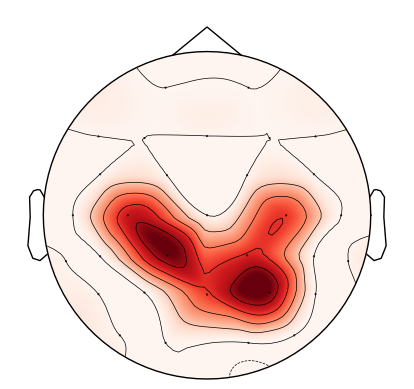

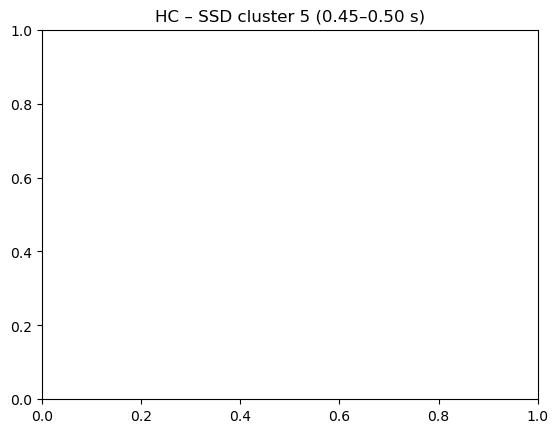

In [135]:
# PLOT ... 
import numpy as np

# Cluster 5 indices
ch_idx, time_idx = clusters[5]

# Average over time points in the cluster for each subject
ssd_cluster_avg = ssd_group_data[:, ch_idx[:, None], time_idx].mean(axis=2).mean(axis=0)  # mean over time & subjects
hc_cluster_avg = hc_group_data[:, ch_idx[:, None], time_idx].mean(axis=2).mean(axis=0)    # mean over time & subjects

from mne.viz import plot_topomap
import matplotlib.pyplot as plt

# Pick an example Evoked to get info
# Pick a valid Evoked object from SSD data
evoked_example = None
for evoked_list in ssd_data_v1["ec"].values():
    if isinstance(evoked_list, list) and len(evoked_list) > 0:
        evoked_example = evoked_list[0]  # pick the first Evoked
        break

if evoked_example is None:
    raise ValueError("No Evoked objects found in ssd_data_v1['ec']")

print(evoked_example)

# Create arrays for topomap
data_to_plot = np.zeros(len(evoked_example.ch_names))
data_to_plot[ch_idx] = hc_cluster_avg  # e.g., HC values

# Plot topomap
fig, ax = plt.subplots()
im, cn = plot_topomap(data_to_plot, evoked_example.info, axes=ax,
                      show=True, names=[evoked_example.ch_names[i] for i in ch_idx])
plt.title("HC cluster 5 (0.45–0.50 s)")
plt.show()

data_diff = np.zeros(len(evoked_example.ch_names))
data_diff[ch_idx] = hc_cluster_avg - ssd_cluster_avg

fig, ax = plt.subplots()
im, cn = plot_topomap(data_diff, evoked_example.info, axes=ax, show=True)
plt.title("HC – SSD cluster 5 (0.45–0.50 s)")
plt.show()


In [55]:
for p in significant_p_vals:
    if p is True:
        print("Significant p-value found")
    else:
        print("No significant p-value found")
# Print the results
print("T-values shape:", t_vals.shape)
print("P-values shape:", p_vals.shape)  
print("T-values:", t_vals)
print("P-values:", p_vals)
print("Corrected P-values shape:", p_vals_corrected.shape)
print("Corrected P-values:", p_vals_corrected)
print("Significant P-values shape:", significant_p_vals.shape)
print("Significant P-values:", significant_p_vals)
# Print the adjacency matrix


No significant p-value found
No significant p-value found
No significant p-value found
No significant p-value found
No significant p-value found
No significant p-value found
No significant p-value found
No significant p-value found
No significant p-value found
No significant p-value found
No significant p-value found
No significant p-value found
No significant p-value found
No significant p-value found
No significant p-value found
No significant p-value found
No significant p-value found
No significant p-value found
No significant p-value found
No significant p-value found
No significant p-value found
No significant p-value found
No significant p-value found
No significant p-value found
No significant p-value found
No significant p-value found
No significant p-value found
No significant p-value found
No significant p-value found
No significant p-value found
No significant p-value found
T-values shape: (31,)
P-values shape: (31,)
T-values: [ 0.8426349   1.75961762  0.10865448  1.3618548

In [27]:
# Get spatial adjacency (correcting channel selection)
adjacency, _ = find_ch_adjacency(evoked.info, ch_type='eeg')

# Option 1: If channels_of_interest are indices, convert to names
if isinstance(channels_of_interest[0], (int, np.integer)):
    channels_of_interest = [evoked.ch_names[i] for i in channels_of_interest]

# Option 2: If names, verify they exist
missing = [ch for ch in channels_of_interest if ch not in evoked.ch_names]
if missing:
    raise ValueError(f"Channels missing in `evoked.ch_names`: {missing}")

# Now subset adjacency
ch_idx = [evoked.ch_names.index(ch) for ch in channels_of_interest]
adjacency = adjacency[ch_idx, :][:, ch_idx]  # Subset to selected channels

Could not find a adjacency matrix for the data. Computing adjacency based on Delaunay triangulations.
-- number of adjacent vertices : 31


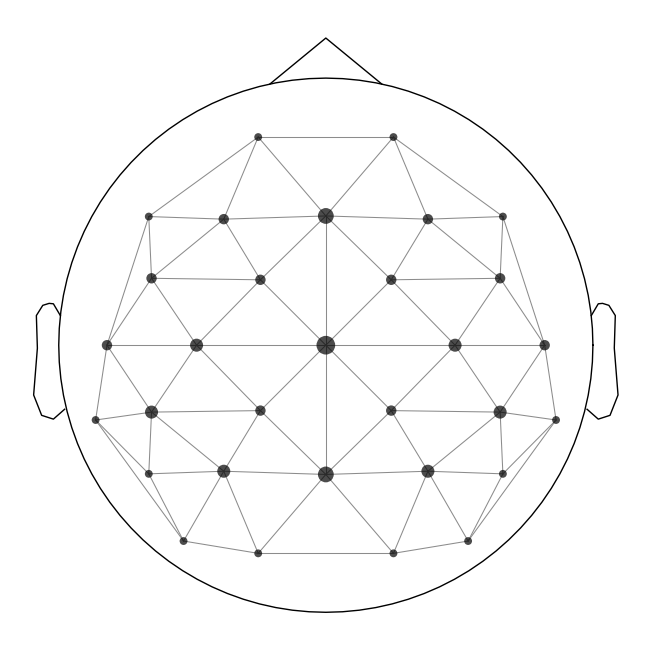

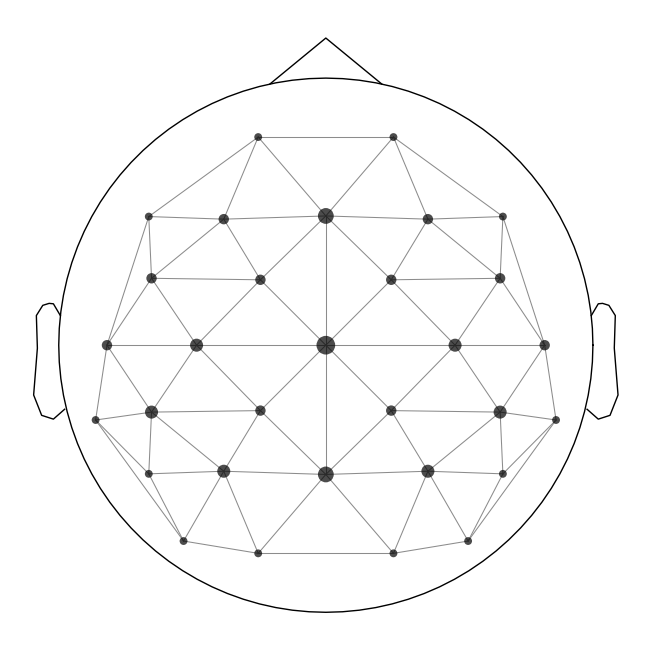

In [6]:
adjacency_plot = mne.viz.plot_ch_adjacency(info=evoked.info, adjacency=adjacency, ch_names=evoked.info['ch_names'])
adjacency_plot


In [139]:
adjacency

<Compressed Sparse Row sparse array of dtype 'int64'
	with 187 stored elements and shape (31, 31)>

Run Permutation Cluster Test

In [83]:
# compute threshold based on p-value
# The F-threshold defines whether an entire cluster of effects is significant based on its spatial/temporal extent and summed T-values.
pval = 0.05  # arbitrary
n_conditions = 2  # SSD and HC
n_observations = ssd_group_data.shape[0] + hc_group_data.shape[0]  # total number of subjects
dfn = n_conditions - 1  # degrees of freedom numerator
dfd = n_observations - n_conditions  # degrees of freedom denominator
threshold =  scipy.stats.f.ppf(1 - pval, dfn=dfn, dfd=dfd) #None #3 #3.5  #  # F distribution
threshold

# Calculate the critical T-value for a two-tailed test with alpha=0.05.
# This threshold is used to determine which T-values are considered "extreme" under the null hypothesis.
# It provides a more liberal criterion compared to cluster-level significance testing, 
# as it evaluates individual T-values without accounting for spatial/temporal adjacency.
# less strict threshhold
# threshold = t.ppf(1 - 0.05 / 2, df=n_observations - 1)  # Two-tailed threshold
# This threshold does not account for spatial/temporal adjacency. It only checks whether a specific data point exceeds the threshold under a null hypothesis. It does not correct for multiple comparisons directly, meaning it's more liberal and prone to false positives.


np.float64(3.9290117179282804)

In [84]:
#threshold = 6.0
T_obs, clusters, cluster_p_values, H0 = permutation_cluster_test(
    [ssd_group_data_time_avg, hc_group_data_time_avg], # this worked BUT when I used the data NOT averaged accross time, it did NOT work! gave me a dim error!
    n_permutations=1000,
    threshold=threshold,
    tail=0,
    adjacency = adjacency,
    n_jobs=None,
    out_type="mask",
)

stat_fun(H1): min=0.0001548511909369856 max=7.3059418510168355
Running initial clustering …
Found 3 clusters


  0%|          | Permuting : 0/999 [00:00<?,       ?it/s]

In [85]:
clusters
#hc_group_data_time_avg.shape
scipy.stats.f.ppf(1 - pval, dfn=dfn, dfd=dfd)  # F distribution

np.float64(3.9290117179282804)

In [86]:
# Check the cluster p-values to see if they are significant
for idx, p_val in enumerate(cluster_p_values):
    if p_val < 0.05:
        print(f"Cluster {idx + 1} is significant (p-value: {p_val})")
    else:
        print(f"Cluster {idx + 1} is not significant (p-value: {p_val})")


Cluster 1 is not significant (p-value: 0.065)
Cluster 2 is not significant (p-value: 0.087)
Cluster 3 is not significant (p-value: 0.602)


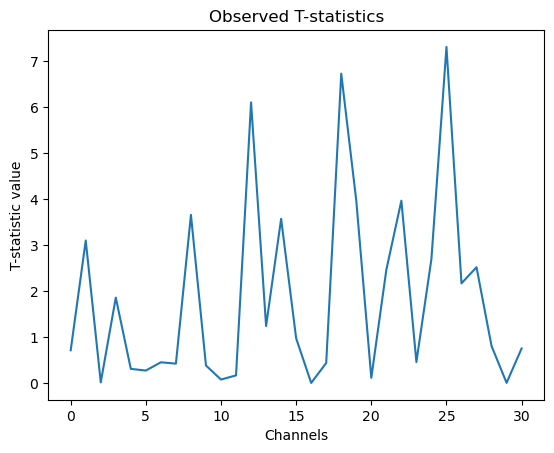

In [87]:
plt.plot(T_obs)  # Simple line plot for T-values across channels
plt.title("Observed T-statistics")
plt.xlabel("Channels")
plt.ylabel("T-statistic value")
plt.show()



['Fp1', 'Fp2', 'F7', 'F3', 'Fz', 'F4', 'F8', 'FC5', 'FC1', 'FC2', 'FC6', 'T7', 'C3', 'Cz', 'C4', 'T8', 'TP9', 'CP5', 'CP1', 'CP2', 'CP6', 'TP10', 'P7', 'P3', 'Pz', 'P4', 'P8', 'PO9', 'O1', 'O2', 'PO10']


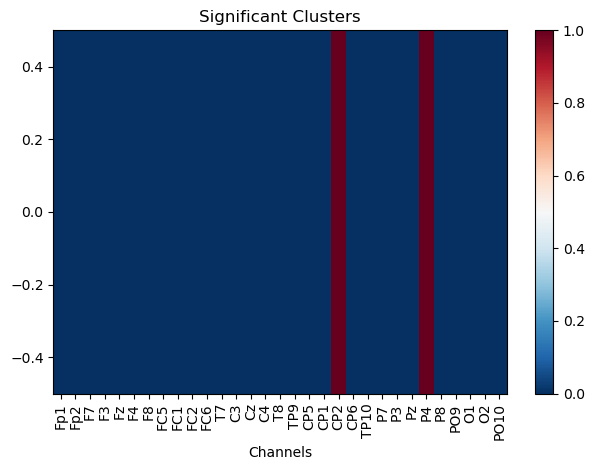

In [90]:

#define channels
channels = ssd_ec_grand_average_hep_evoked.info["ch_names"]
print(channels)


##  visualize the first cluster mask in a 2D format, even though the cluster is essentially a 1D boolean array. meaning only channels that form a cluster will be 1 and rest will be 0

# # Visualize cluster mask (significant regions)
plt.imshow(clusters[1].reshape(1, -1), cmap='RdBu_r', aspect='auto', origin='lower')
# Add colorbar
plt.colorbar()
# Add title and labels
plt.title("Significant Clusters")
plt.xlabel("Channels")
# Customize x-axis to show channel names
plt.xticks(ticks=np.arange(len(channels)), labels=channels, rotation=90)
# Show the plot
plt.tight_layout()
plt.show()



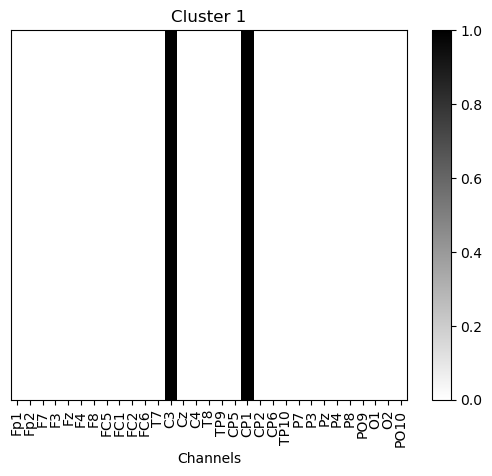

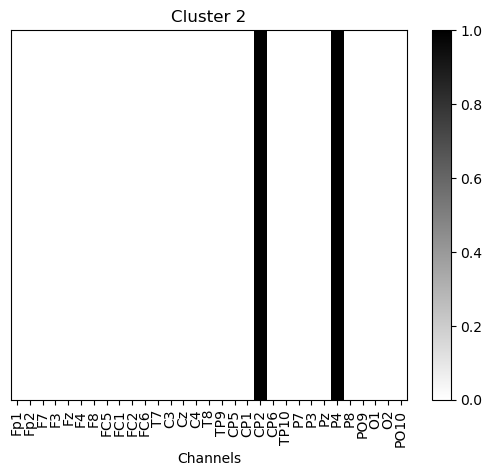

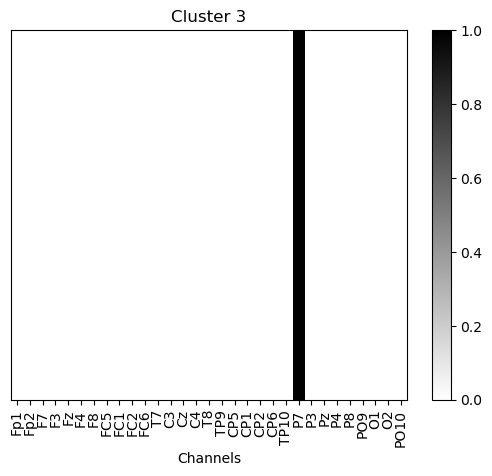

In [91]:
for idx, cluster_mask in enumerate(clusters):
    plt.imshow(cluster_mask.reshape(1, -1), cmap='binary', aspect='auto', origin='lower')
    plt.colorbar()
    plt.title(f"Cluster {idx + 1}")
    plt.xlabel("Channels")
    plt.xticks(ticks=np.arange(len(channels)), labels=channels, rotation=90)
    plt.yticks([])  # No meaningful row axis
    plt.show()



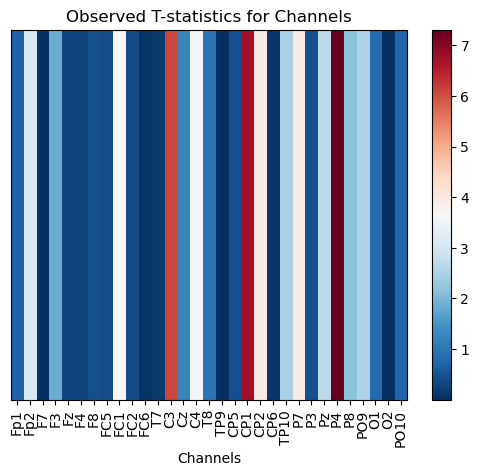

In [92]:
# Reshape T_obs to 2D for visualization,  We have time-averaged data (e.g., shape: (1, 31) for 31 channels)
T_obs_reshaped = T_obs.reshape(1, -1)  # # Reshape to 2D for visualization (required for plt.imshow) while preserving the data's original structure.

# Visualize the observed T-values
plt.imshow(T_obs_reshaped, cmap='RdBu_r', aspect='auto', origin='lower')
plt.colorbar()
plt.title("Observed T-statistics for Channels")
plt.xlabel("Channels")
plt.xticks(ticks=np.arange(len(channels)), labels=channels, rotation=90)
plt.yticks([])  # No meaningful time axis in this case
plt.show()



(31,)


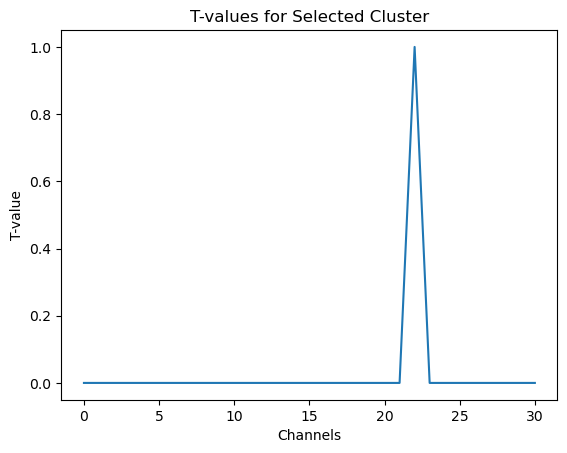

In [93]:
print(cluster_mask.shape)

# Visualize the T-values of the clusters across the channels
plt.plot(cluster_mask)  
plt.title("T-values for Selected Cluster")
plt.xlabel("Channels")
plt.ylabel("T-value")
plt.show()


In [113]:
# Ensure common channel names are in the same order
common_ch_names = list(set(evoked.info["ch_names"]) & set(ch_names))

# Sort both the data and the adjacency matrix channels by the common channel names
common_ch_names_sorted = sorted(common_ch_names, key=lambda x: evoked.info["ch_names"].index(x))

# Reorder the data accordingly
ssd_group_data = ssd_group_data[:, [evoked.info["ch_names"].index(ch) for ch in common_ch_names_sorted]]
hc_group_data = hc_group_data[:, [evoked.info["ch_names"].index(ch) for ch in common_ch_names_sorted]]

# Regenerate adjacency to reflect the same order
adjacency, _ = find_ch_adjacency(evoked.info, ch_type="eeg")

# Ensure both channel lists are identical and sorted the same way
assert common_ch_names_sorted == ch_names, "Channel names do not match after sorting!"


Could not find a adjacency matrix for the data. Computing adjacency based on Delaunay triangulations.
-- number of adjacent vertices : 31


In [122]:

# Assuming T_obs is reshaped to (n_channels, n_times)
n_channels = ssd_group_data.shape[1]
n_times = ssd_group_data.shape[2]

# Reshape T_obs to match the data structure: (n_channels, n_times)
T_obs_reshaped = T_obs.reshape(n_channels, n_times)

# Visualize the clusters
for idx, cluster in enumerate(clusters):
    # Check if the cluster is significant
    if cluster_p_values[idx] < 0.05:
        # Plot the observed T-statistics with the cluster mask applied
        plt.imshow(T_obs_reshaped * cluster, aspect="auto", cmap="coolwarm", origin="lower")
        plt.colorbar()
        plt.title(f"Cluster {idx + 1} (p-value: {cluster_p_values[idx]})")
        plt.xlabel("Time (ms)")
        plt.ylabel("Channels")
        plt.show()


ValueError: cannot reshape array of size 31 into shape (31,12)

In [95]:
# Get the time points where clusters are significant
for idx, cluster in enumerate(clusters):
    if cluster_p_values[idx] < 0.05:
        cluster_times = [t for t, is_significant in enumerate(cluster) if is_significant]
        print(f"Cluster {idx + 1} significant time points: {cluster_times}")


In [ ]:
# change this for your needs

# picks = mne.pick_types(raw.info, meg=False, eog=True, include=include, exclude="bads")
event_id = 1
reject = dict(grad=4000e-13, eog=150e-6)
epochs1 = mne.Epochs(
    raw, events, event_id, tmin, tmax, picks=picks, baseline=(None, 0), reject=reject
)
condition1 = epochs1.get_data()  # as 3D matrix

event_id = 2
epochs2 = mne.Epochs(
    raw, events, event_id, tmin, tmax, picks=picks, baseline=(None, 0), reject=reject
)
condition2 = epochs2.get_data()  # as 3D matrix

condition1 = condition1[:, 0, :]  # take only one channel to get a 2D array
condition2 = condition2[:, 0, :]  # take only one channel to get a 2D array


In [107]:
# Initialize lists for patients
eyes_closed_heps = []
eyes_open_heps = []
hct_heps = []

# Initialize lists for healthy controls (HCs)
eyes_closed_heps_hc = []
eyes_open_heps_hc = []
hct_heps_hc = []

# Iterate through imported_data and classify based on key
for key, value in imported_data_V1.items():
    if isinstance(value, list):  # Ensure value is a list
        value = value[0]  # Take the first Evoked object

    if "eyes-closed" in key and "SCZ" in key:
        eyes_closed_heps.append(value)
    elif "eyes-open" in key and "SCZ" in key:
        eyes_open_heps.append(value)
    elif "hct" in key and "SCZ" in key:
        hct_heps.append(value)

# For healthy controls (HCs)
for key, value in imported_data_hc.items():
    if isinstance(value, list):  # Ensure value is a list
        value = value[0]  # Take the first Evoked object

    if "eyes-closed" in key and "BHC" in key:
        eyes_closed_heps_hc.append(value)
    elif "eyes-open" in key and "BHC" in key:
        eyes_open_heps_hc.append(value)
    elif "hct" in key and "BHC" in key:
        hct_heps_hc.append(value)

# Compute grand averages for patients
grand_average_eyes_closed_hep_evoked = mne.grand_average(eyes_closed_heps)
grand_average_eyes_open_hep_evoked = mne.grand_average(eyes_open_heps)
grand_average_hct_hep_evoked = mne.grand_average(hct_heps)

# Compute grand averages for HCs
grand_average_eyes_closed_hep_evoked_hc = mne.grand_average(eyes_closed_heps_hc)
grand_average_eyes_open_hep_evoked_hc = mne.grand_average(eyes_open_heps_hc)
grand_average_hct_hep_evoked_hc = mne.grand_average(hct_heps_hc)

# Print the number of items in each list to verify
print(f"Eyes Closed SCZ: {len(eyes_closed_heps)}")
print(f"Eyes Open SCZ: {len(eyes_open_heps)}")
print(f"HCT SCZ: {len(hct_heps)}")
print(f"Eyes Closed HC: {len(eyes_closed_heps_hc)}")
print(f"Eyes Open HC: {len(eyes_open_heps_hc)}")
print(f"HCT HC: {len(hct_heps_hc)}")

NameError: name 'imported_data_V1' is not defined

In [108]:

# Boolean mask of all significant points (time x channels)
sig_mask = np.any([clusters[i_c] for i_c, p_val in enumerate(cluster_p_values) if p_val < 0.10], axis=0)
sig_mask

# Get channels in the significant cluster
sig_channels = np.any(sig_mask, axis=0)  # True for channels involved
sig_channels

# Compute grand averages for patients
grand_average_eyes_closed_hep_evoked = mne.grand_average(eyes_closed_heps)
grand_average_eyes_open_hep_evoked = mne.grand_average(eyes_open_heps)
grand_average_hct_hep_evoked = mne.grand_average(hct_heps)

# Compute grand averages for HCs
grand_average_eyes_closed_hep_evoked_hc = mne.grand_average(eyes_closed_heps_hc)
grand_average_eyes_open_hep_evoked_hc = mne.grand_average(eyes_open_heps_hc)
grand_average_hct_hep_evoked_hc = mne.grand_average(hct_heps_hc)

ValueError: Please pass a list of Evoked or AverageTFR objects.

In [106]:


# Average ERP over these channels
erp_cond1 = grand_average_eyes_closed_hep_evoked[:, sig_channels, :].mean(axis=1).mean(axis=1)  # mean over channels and subjects
erp_cond2 = grand_average_eyes_closed_hep_evoked_hc[:, sig_channels, :].mean(axis=1).mean(axis=1)




plt.figure(figsize=(8,4))
plt.plot(grand_average_eyes_closed_hep_evoked.times, grand_average_eyes_closed_hep_evoked, label='SSD')
plt.plot(grand_average_eyes_closed_hep_evoked_hc.times, grand_average_eyes_closed_hep_evoked_hc, label='HC')
plt.fill_between(times, erp_cond1_mean, erp_cond2_mean, where=sig_mask[sig_channels, :].any(axis=0),
                 color='red', alpha=0.3, label='Significant cluster')
plt.xlabel('Time (s)')
plt.ylabel('ERP amplitude (µV)')
plt.title('ERPs of significant cluster')
plt.legend()
plt.show()

import mne

# Average across time points in cluster
times_idx = np.any(sig_mask[sig_channels, :], axis=0)
mean_erp = (X_cond1[:, :, :].mean(axis=0) - X_cond2[:, :, :].mean(axis=0))[:, times_idx].mean(axis=1)

# Plot topomap
mne.viz.plot_topomap(mean_erp, evoked.info, show=True)

NameError: name 'grand_average_eyes_closed_hep_evoked' is not defined

Plot sig clusters

In [99]:
# Define the file paths for the evoked data
evoked_file_paths = ["/Users/denizyilmaz/Desktop/BrainTrain/BrainTrain_EEG_data/Preprocessed_until_ICA/sampling-250_bandpass-0.30-45.00_line-50_find_all_bads/Preprocessed_ICA_applied_on_raw/HEPs/HEPs_hep-epoch--0.25-0.55_baseline--0.12--0.03_epoch-reject-1.50e-04_33%-bad-epochs-threshold_HEP-time_window-0.45-0.50/heps_list_V1_eyes_closed-ave.fif",
                     "/Users/denizyilmaz/Desktop/BrainTrain/Healthy Controls_BHC/BrainTrain_EEG_data_HC/HC_Preprocessed_until_ICA/sampling-250_bandpass-0.30-45.00_line-50_find_all_bads/HC_Preprocessed_ICA_applied_on_raw/HEPs/HEPs_hep-epoch--0.25-0.55_baseline--0.12--0.03_epoch-reject-1.50e-04_33%-bad-epochs-threshold_HEP-time_window-0.45-0.50/HC_heps_list_V1_eyes_closed-ave.fif"]
# Time range for analysis
tmin = 0.45  # Start of the HEP in seconds
tmax = 0.50  # End of the HEP in seconds

# Load the evoked data
evoked_list = []
for file_path in evoked_file_paths:
    evoked = mne.read_evokeds(file_path)
    evoked_list.append(evoked)
# Create a list of evoked objects
# Assuming you have two evoked objects for two conditions
evoked_ssd = evoked_list[0]
evoked_hc = evoked_list[1]
# Create a list of evoked objects
evoked_list = [evoked_ssd, evoked_hc]

Reading /Users/denizyilmaz/Desktop/BrainTrain/BrainTrain_EEG_data/Preprocessed_until_ICA/sampling-250_bandpass-0.30-45.00_line-50_find_all_bads/Preprocessed_ICA_applied_on_raw/HEPs/HEPs_hep-epoch--0.25-0.55_baseline--0.12--0.03_epoch-reject-1.50e-04_33%-bad-epochs-threshold_HEP-time_window-0.45-0.50/heps_list_V1_eyes_closed-ave.fif ...
    Found the data of interest:
        t =    -248.00 ...     552.00 ms (R-peak)
        0 CTF compensation matrices available
        nave = 415 - aspect type = 100
No projector specified for this dataset. Please consider the method self.add_proj.
Loaded Evoked data is baseline-corrected (baseline: [-0.125, -0.025] s)
    Found the data of interest:
        t =    -248.00 ...     552.00 ms (R-peak)
        0 CTF compensation matrices available
        nave = 299 - aspect type = 100
No projector specified for this dataset. Please consider the method self.add_proj.
Loaded Evoked data is baseline-corrected (baseline: [-0.125, -0.025] s)
    Found the data

In [100]:
len(hc_data['hct'])
file_name
print(hc_data['eo'])
print(all_bad_subs_names)


NameError: name 'file_name' is not defined

In [72]:
# Check if any key in hc_data['eo'] matches an entry in all_bad_subs_names
matches = [key for key in hc_data['eo'].keys() if any(bad_sub in key for bad_sub in all_bad_subs_names)]

# Print the results
if matches:
    print(f"The following keys in hc_data['eo'] match entries in all_bad_subs_names: {matches}")
else:
    print("No keys in hc_data['eo'] match any entry in all_bad_subs_names.")


No keys in hc_data['eo'] match any entry in all_bad_subs_names.


In [ ]:

def prepare_data(task_key, ssd_data, hc_data, time_window=None):
    """
    Prepare numpy arrays for a specific task from SSD and HC data dictionaries.
    
    Parameters:
        task_key (str): Task identifier ('ec', 'eo', 'hct').
        ssd_data (dict): Dictionary storing SSD data for each task.
        hc_data (dict): Dictionary storing HC data for each task.
        time_window (tuple): Start and end times for cropping (e.g., (0.45, 0.50)).

    Returns:
        tuple: Arrays for SSD and HC groups (n_subjects, n_time_points).
    """
    def extract_data(group_data):
        group_arrays = []
        for file_name, evoked in group_data.items():
            # Extract the data array from Evoked object
            data = evoked.data  # Shape: (n_channels, n_time_points)
            
            # Select only one channel if needed (e.g., average over channels or pick specific ones)
            # For now, we'll assume the data is already processed to a single dimension.
            if data.shape[0] > 1:
                data = np.mean(data, axis=0)  # Average over channels
            
            # Crop to the time window if specified
            if time_window is not None:
                time_indices = (evoked.times >= time_window[0]) & (evoked.times <= time_window[1])
                data = data[time_indices]
            
            group_arrays.append(data)
        
        return np.array(group_arrays)  # Shape: (n_subjects, n_time_points)

    # Extract and align data for the task
    ssd_array = extract_data(ssd_data[task_key])
    hc_array = extract_data(hc_data[task_key])
    
    return ssd_array, hc_array


In [194]:
# Define the time window of interest
time_min = 0.15 #0.45
time_max = 0.55#0.7 #0.50
# Specify the task and channels
task = "ec"  # Example: "ec", "eo", or "hct"
channels_of_interest = list(range(0, 31))  # Example: indices of the desired channels

# Extract SSD group data
ssd_group_data = []
for evoked in ssd_data_v1[task].values():
    if isinstance(evoked, list):  # Check if it's a list
        evoked = evoked[0]       # Take the first element
        time_mask = (evoked.times >= time_min) & (evoked.times <= time_max)
        data = evoked.data[channels_of_interest, :][:, time_mask]  # Select channels
        ssd_group_data.append(data)
        adjacency, ch_nameslist = find_ch_adjacency(evoked.info, ch_type='eeg')  # Assuming `hc_data` contains the info attribute

        # Subset adjacency to match channels_of_interest
        ch_idx = channels_of_interest
        adjacency = adjacency[ch_idx, :][:, ch_idx]  # Subset adjacency

        
        # Combine spatial (EEG) and temporal adjacency
        n_times = data.shape[1]  # Number of time points after masking
        # temporal_adj = mne.stats.combine_adjacency(n_times, n_times)  # Linear time adjacency
        temporal_adj = np.eye(n_times, k=1) + np.eye(n_times, k=-1)  # neighbors are adjacent time points

        
        #combined_adj = mne.stats.combine_adjacency(
        #    adjacency.shape[0],  # Spatial (channels)
        #    n_times,            # Temporal
        #    adjacency          # Spatial adjacency (subset)
        #)
        
                # Combine
        combined_adj = mne.stats.combine_adjacency(adjacency, temporal_adj)

        print("Channels:", channels_of_interest)
        print("Spatial Adjacency shape:", adjacency.shape)
        print("Combined adjacency shape:", combined_adj.shape)




        #combined_adj = mne.stats.combine_adjacency(len(channels_of_interest),
        #                    shape_ssd[2],   # regular lattice adjacency for times 
        #                  #np.zeros((n_freqs, n_freqs)),  # no adjacency between freq. bins
        #                  adjacency  # custom matrix, or use mne.channels.find_ch_adjacency
        #                  )
        #channels = evoked.info['ch_names']
        #print("Channels:", channels)
        #print("Adjacency:", adjacency)
ssd_group_data = np.array(ssd_group_data)  # Shape:

# Extract HC group data
hc_group_data = []
for evoked in hc_data[task].values():
    if isinstance(evoked, list):  # Check if it's a list
        evoked = evoked[0]       # Take the first element
        time_mask = (evoked.times >= time_min) & (evoked.times <= time_max)
        data = evoked.data[channels_of_interest, :][:, time_mask]  # Select channels
    hc_group_data.append(data)
hc_group_data = np.array(hc_group_data)  # Shape: (n_subjects, n_channels, n_times)

shape_ssd = ssd_group_data.shape
shape_hc = hc_group_data.shape
print(f"SSD group data shape: {shape_ssd} indicating {shape_ssd[0]} subjects, {shape_ssd[1]} channels, {shape_ssd[2]} time points")
print(f"HC group data shape: {shape_hc} indicating {shape_hc[0]} subjects, {shape_hc[1]} channels, {shape_hc[2]} time points")

# average ssd_group_data on time domain
ssd_group_data_time_avg = np.mean(ssd_group_data, axis=2)
hc_group_data_time_avg = np.mean(hc_group_data, axis=2)

print("SSD group data shape after averaging over time domain:", ssd_group_data_time_avg.shape, "indicating ", ssd_group_data_time_avg.shape[0], "subjects, ", ssd_group_data_time_avg.shape[1], "channels")
print("HC group data shape after averaging over time domain:", hc_group_data_time_avg.shape, "indicating ", hc_group_data_time_avg.shape[0], "subjects, ", hc_group_data_time_avg.shape[1], "channels")

######
# ADD combine_adjacency !
# then do: https://mne.tools/stable/generated/mne.stats.spatio_temporal_cluster_test.html


Could not find a adjacency matrix for the data. Computing adjacency based on Delaunay triangulations.
-- number of adjacent vertices : 31
Channels: [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30]
Spatial Adjacency shape: (31, 31)
Combined adjacency shape: (372, 372)
Could not find a adjacency matrix for the data. Computing adjacency based on Delaunay triangulations.
-- number of adjacent vertices : 31
Channels: [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30]
Spatial Adjacency shape: (31, 31)
Combined adjacency shape: (372, 372)
Could not find a adjacency matrix for the data. Computing adjacency based on Delaunay triangulations.
-- number of adjacent vertices : 31
Channels: [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30]
Spatial Adjacency shape: (31, 31)
Combined adjacency shape: (372, 372